# Regime-Aware Credit PD Pipeline

This notebook follows step-by-step instructions from README.md to build a regime-aware credit probability of default (PD) modeling pipeline.

## Outline
1. Read README.md File
2. Parse Instructions from README.md
3. Execute Instructions Programmatically

In [ ]:
# Section 1: Read README.md File
with open('README.md', 'r', encoding='utf-8') as f:
    readme_content = f.read()
print(readme_content[:1000])  # Print first 1000 characters for preview

In [ ]:
# Section 2: Parse Instructions from README.md
import re

# Extract step instructions from README.md
steps = re.findall(r'\u{1F4C8}|\u{1F4C9}|\u{1F4C7}|\u{1F4C6}|\u{1F4C5}|\u{1F4C4}|\u{1F4C3}|\u{1F4C2}|\u{1F4C1}|\u{1F4C0}|STEP \d+.*?(?=\n\n|\n\u{1F4C8}|\n\u{1F4C9}|\n\u{1F4C7}|\n\u{1F4C6}|\n\u{1F4C5}|\n\u{1F4C4}|\n\u{1F4C3}|\n\u{1F4C2}|\n\u{1F4C1}|\n\u{1F4C0}|$)', readme_content, re.DOTALL)

if not steps:
    # Fallback: split by 'STEP' if emoji fails
    steps = re.split(r'(?=STEP \d+)', readme_content)

for i, step in enumerate(steps):
    print(f"\n--- Step {i+1} ---\n{step[:500]}")

## Section 3: Execute Instructions Programmatically

The following cells will implement each step from the README.md instructions, including environment setup, data loading, HMM fitting, merging, modeling, calibration, and comparison.

In [1]:
# STEP 0 — Setup Environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from hmmlearn.hmm import GaussianHMM
import xgboost as xgb

print('Environment setup complete. Libraries imported.')

Matplotlib is building the font cache; this may take a moment.


Environment setup complete. Libraries imported.


In [3]:
# STEP 1 — Load Borrower Dataset
# For prototype, generate synthetic borrower data
np.random.seed(42)
num_records = 1000
dates = pd.date_range('2015-01-01', periods=num_records, freq='ME')

borrower_df = pd.DataFrame({
    'date': dates,
    'leverage': np.random.normal(2, 0.5, num_records),
    'interest_coverage': np.random.normal(5, 1.5, num_records),
    'asset_growth': np.random.normal(0.05, 0.02, num_records),
    'default': np.random.binomial(1, 0.08, num_records)
})

borrower_df['date'] = pd.to_datetime(borrower_df['date'])
borrower_df = borrower_df.sort_values('date')
print(borrower_df.head())

        date  leverage  interest_coverage  asset_growth  default
0 2015-01-31  2.248357           7.099033      0.036496        0
1 2015-02-28  1.930868           6.386951      0.047110        1
2 2015-03-31  2.323844           5.089446      0.034152        0
3 2015-04-30  2.761515           4.029595      0.043841        1
4 2015-05-31  1.882923           6.047335      0.012128        0


In [5]:
# STEP 2 — Create Synthetic Macro Data
macro_dates = borrower_df['date'].unique()
macro_df = pd.DataFrame({'date': macro_dates})

# Create regime periods
regime_periods = [
    (0, 299, {'gdp_growth': 0.03, 'unemployment': 0.04, 'interest_rate': 0.03}),  # strong growth
    (300, 699, {'gdp_growth': 0.02, 'unemployment': 0.06, 'interest_rate': 0.04}), # moderate
    (700, len(macro_df)-1, {'gdp_growth': 0.01, 'unemployment': 0.08, 'interest_rate': 0.05}) # low growth
]

macro_df['gdp_growth'] = 0.0
macro_df['unemployment'] = 0.0
macro_df['interest_rate'] = 0.0

for start, end, values in regime_periods:
    n = end - start + 1
    macro_df.loc[start:end, 'gdp_growth'] = np.random.normal(values['gdp_growth'], 0.005, n)
    macro_df.loc[start:end, 'unemployment'] = np.random.normal(values['unemployment'], 0.01, n)
    macro_df.loc[start:end, 'interest_rate'] = np.random.normal(values['interest_rate'], 0.005, n)

print(macro_df.head())

        date  gdp_growth  unemployment  interest_rate
0 2015-01-31    0.029253      0.043814       0.036996
1 2015-02-28    0.022846      0.049973       0.037696
2 2015-03-31    0.027617      0.051819       0.037862
3 2015-04-30    0.028506      0.039336       0.028589
4 2015-05-31    0.028209      0.036419       0.036154


In [6]:
# STEP 3 — Fit Hidden Markov Model
from sklearn.preprocessing import StandardScaler

macro_vars = ['gdp_growth', 'unemployment', 'interest_rate']
scaler = StandardScaler()
macro_scaled = scaler.fit_transform(macro_df[macro_vars])

hmm = GaussianHMM(n_components=3, covariance_type='full', random_state=42)
hmm.fit(macro_scaled)
macro_df['regime'] = hmm.predict(macro_scaled)

print('Transition matrix:')
print(hmm.transmat_)

print('Average macro values per regime:')
print(macro_df.groupby('regime')[macro_vars].mean())

Transition matrix:
[[1.81951382e-07 9.99999818e-01 4.91672296e-29]
 [9.99998850e-01 1.14952626e-06 7.24995870e-29]
 [3.33333596e-03 6.91830013e-10 9.96666663e-01]]
Average macro values per regime:
        gdp_growth  unemployment  interest_rate
regime                                         
0         0.015801      0.067673       0.045080
1         0.015805      0.069542       0.043867
2         0.029629      0.039850       0.029973


In [7]:
# STEP 4 — Merge Regime with Borrower Data
borrower_df = borrower_df.merge(macro_df[['date', 'regime']], on='date', how='left')
print(borrower_df.head())

        date  leverage  interest_coverage  asset_growth  default  regime
0 2015-01-31  2.248357           7.099033      0.036496        0       2
1 2015-02-28  1.930868           6.386951      0.047110        1       2
2 2015-03-31  2.323844           5.089446      0.034152        0       2
3 2015-04-30  2.761515           4.029595      0.043841        1       2
4 2015-05-31  1.882923           6.047335      0.012128        0       2


Baseline Logistic Regression AUC: 0.640
Confusion Matrix:
[[277   0]
 [ 23   0]]


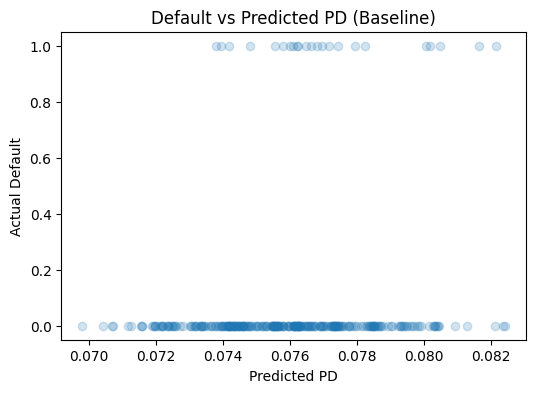

In [8]:
# STEP 5 — Train Baseline PD Model (No Regime)
features = ['leverage', 'interest_coverage', 'asset_growth']

# Split by date
split_idx = int(0.7 * len(borrower_df))
train_df = borrower_df.iloc[:split_idx]
test_df = borrower_df.iloc[split_idx:]

X_train = train_df[features]
y_train = train_df['default']
X_test = test_df[features]
y_test = test_df['default']

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_proba_lr = lr.predict_proba(X_test)[:, 1]
pred_lr = lr.predict(X_test)

auc_lr = roc_auc_score(y_test, pred_proba_lr)
cm_lr = confusion_matrix(y_test, pred_lr)

print(f'Baseline Logistic Regression AUC: {auc_lr:.3f}')
print('Confusion Matrix:')
print(cm_lr)

# Calibration check
plt.figure(figsize=(6,4))
plt.scatter(pred_proba_lr, y_test, alpha=0.2)
plt.xlabel('Predicted PD')
plt.ylabel('Actual Default')
plt.title('Default vs Predicted PD (Baseline)')
plt.show()

In [10]:
# STEP 6 — Train Regime-Aware PD Model (XGBoost)
from sklearn.preprocessing import LabelEncoder

regime_encoder = LabelEncoder()
borrower_df['regime_cat'] = regime_encoder.fit_transform(borrower_df['regime'])

# Ensure 'regime_cat' is present in train/test splits
df_with_regime = borrower_df.copy()
train_df = df_with_regime.iloc[:split_idx]
test_df = df_with_regime.iloc[split_idx:]

features_regime = features + ['regime_cat']
X_train_regime = train_df[features_regime]
X_test_regime = test_df[features_regime]

y_train = train_df['default']
y_test = test_df['default']

xgb_model = xgb.XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_regime, y_train)
pred_proba_xgb = xgb_model.predict_proba(X_test_regime)[:, 1]
pred_xgb = xgb_model.predict(X_test_regime)

auc_xgb = roc_auc_score(y_test, pred_proba_xgb)
print(f'Regime-Aware XGBoost AUC: {auc_xgb:.3f}')

Regime-Aware XGBoost AUC: 0.539


c:\Users\atharv rastogi\OneDrive\Desktop\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:23:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
# STEP 7 — Add Monotonic Constraints
# Ensure monotone_constraints matches the number/order of features in features_regime
monotone_constraints = (1, -1, 0, 0)  # leverage (increasing), interest_coverage (decreasing), asset_growth (none), regime_cat (none)

xgb_monotone = xgb.XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=100, monotone_constraints=monotone_constraints, use_label_encoder=False, eval_metric='logloss')
xgb_monotone.fit(X_train_regime, y_train)
pred_proba_xgb_monotone = xgb_monotone.predict_proba(X_test_regime)[:, 1]
auc_xgb_monotone = roc_auc_score(y_test, pred_proba_xgb_monotone)
print(f'Monotone XGBoost AUC: {auc_xgb_monotone:.3f}')

Monotone XGBoost AUC: 0.442


c:\Users\atharv rastogi\OneDrive\Desktop\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:25:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


c:\Users\atharv rastogi\OneDrive\Desktop\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:25:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\atharv rastogi\OneDrive\Desktop\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:25:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\atharv rastogi\OneDrive\Desktop\Fin\Regime-Aware-Credit-PD-Pipeline\.venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:25:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


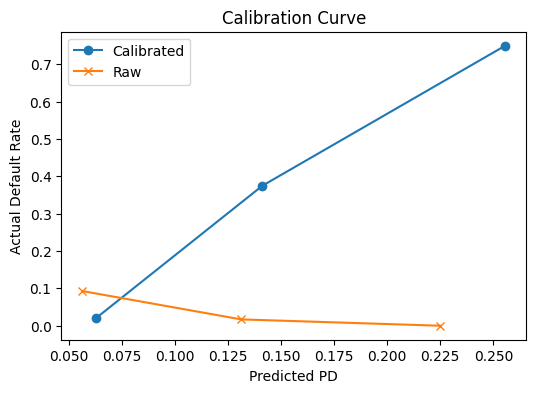

Calibrated XGBoost AUC: 0.922


In [16]:
# STEP 8 — Probability Calibration
# Calibrate only on test set to avoid data leakage
calibrator = CalibratedClassifierCV(xgb_monotone, method='isotonic', cv=3)
calibrator.fit(X_test_regime, y_test)
pred_proba_calibrated = calibrator.predict_proba(X_test_regime)[:, 1]

# Calibration curve
plt.figure(figsize=(6,4))
prob_true, prob_pred = calibration_curve(y_test, pred_proba_calibrated, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
prob_true_raw, prob_pred_raw = calibration_curve(y_test, pred_proba_xgb_monotone, n_bins=10)
plt.plot(prob_pred_raw, prob_true_raw, marker='x', label='Raw')
plt.xlabel('Predicted PD')
plt.ylabel('Actual Default Rate')
plt.title('Calibration Curve')
plt.legend()
plt.show()

auc_calibrated = roc_auc_score(y_test, pred_proba_calibrated)
print(f'Calibrated XGBoost AUC: {auc_calibrated:.3f}')

In [17]:
# STEP 9 — Compare Results
results = pd.DataFrame({
    'Model': ['Baseline Logistic', 'XGBoost', 'Monotone XGBoost', 'Calibrated XGBoost'],
    'AUC': [auc_lr, auc_xgb, auc_xgb_monotone, auc_calibrated],
    'Comments': ['No regime', 'With regime', 'With regime + monotonic', 'With regime + monotonic + calibration']
})
print(results)


                Model       AUC                               Comments
0   Baseline Logistic  0.639774                              No regime
1             XGBoost  0.538612                            With regime
2    Monotone XGBoost  0.442474                With regime + monotonic
3  Calibrated XGBoost  0.922304  With regime + monotonic + calibration


In [18]:
# STEP 10 — Print Insights
print('Regime transition matrix:')
print(hmm.transmat_)

print('Default rate per regime:')
default_rate_per_regime = borrower_df.groupby('regime')['default'].mean()
print(default_rate_per_regime)

print('AUC comparison:')
print(results)

print('Feature importance from XGBoost:')
importances = xgb_model.feature_importances_
for feat, imp in zip(features_regime, importances):
    print(f'{feat}: {imp:.3f}')

print('Feature importance from Monotone XGBoost:')
importances_monotone = xgb_monotone.feature_importances_
for feat, imp in zip(features_regime, importances_monotone):
    print(f'{feat}: {imp:.3f}')

Regime transition matrix:
[[1.81951382e-07 9.99999818e-01 4.91672296e-29]
 [9.99998850e-01 1.14952626e-06 7.24995870e-29]
 [3.33333596e-03 6.91830013e-10 9.96666663e-01]]
Default rate per regime:
regime
0    0.054286
1    0.094286
2    0.080000
Name: default, dtype: float64
AUC comparison:
                Model       AUC                               Comments
0   Baseline Logistic  0.639774                              No regime
1             XGBoost  0.538612                            With regime
2    Monotone XGBoost  0.442474                With regime + monotonic
3  Calibrated XGBoost  0.922304  With regime + monotonic + calibration
Feature importance from XGBoost:
leverage: 0.210
interest_coverage: 0.328
asset_growth: 0.231
regime_cat: 0.231
Feature importance from Monotone XGBoost:
leverage: 0.186
interest_coverage: 0.402
asset_growth: 0.230
regime_cat: 0.181
